In [5]:
# Importing dependencies

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.formula.api import ols
import itertools
warnings.filterwarnings("ignore")

# Problem 1:

In this section, we simulate the equations (1) and (2) given in the question set in order to understand the omitted variable bias.

Equation (1):  
$$
Y(i) = \alpha + \beta x_i + \gamma w_i + \delta z_i + \varepsilon_i
$$

Equation (2):  
$$
Y(i) = \alpha + \beta x_i + \gamma w_i + \mu_i
$$


##### Part a. 

It is given that $ \varepsilon_i $ follows the standard OLS Assumptions. We work with the following assumptions of the error distribution:

1. Error $ \varepsilon_i $ follows a normal distribution ~ $ N (0,\sigma^2) $
2. $ \varepsilon_i $ is exogenous - Mean of $ \varepsilon_i $ is independent of $ X_i $
    - That is $ E [\varepsilon_i | X_i] = 0 $
3. $ \varepsilon_i $ has a constant variance: $ Var[\varepsilon | X] = \sigma^2 $


Now, given, that Equation (2) omits variable $ z_i $, we can say that the error $ \mu_i $ can be represented as $ \mu_i = \delta z_i + \varepsilon_i $

Now, lets check whether the exogeneity assumption satisfies for $ \mu_i $. 

$$

E[\mu_i | x_i, w_i] = E[\delta z_i + \varepsilon_i | x_i, w_i]

$$
$$

\implies \delta E[z_i | x_i, w_i] + E[\varepsilon_i | x_i, w_i]

$$

We know that $\varepsilon_i$ is exogenous. Therefore $E[\varepsilon_i | x_i, w_i] = 0$. 

But, $E[z_i | x_i, w_i] = 0$ iff $\rho(zi, (xi,wi)) = 0$. That is if $z_i$ is uncorrelated with both $x_i$ and $w_i$. Otherwise $E[z_i | x_i, w_i] \neq 0$


Thus the exogeneity assumption breaks down in the error of Equation (2). 

The vairance of $\mu_i$ will be as follows: 

$$

Var(\mu_i) = Var(\delta z_i + \varepsilon_i)

$$

$$

\implies \delta^2 Var(z_i) + Var(\varepsilon_i) + 2 Cov (z_i, \varepsilon_i)

$$

We know that $Var(\varepsilon_i) = \sigma^2$. Even if the $Cov(z_i, \varepsilon_i) = 0$, the $Var(\mu_i)$ increases by $\delta^2 Var(z_i)$

Thus the constant variance assumption breaks down for $\mu_i$ as well. 

##### Part b and c.

**Effect of exogeneity failure on $\alpha$ , $\beta$ and $\delta$ :** 

We know that OLS provides the Best Linear Unbiased Estimators under the Gauss Markov Assumptions. We have considered the Gauss Markov Assumptions for equation 1. Hence we can call the estimated parameters $\phi = (\alpha, \beta, \gamma)$, BLUE. Being Blue means that the parameter estimated is unbiased and has the lowest variance(best). 

Further, for an estimator to be unbiased, the necessary condition is that the exogeneity assumption is satisfied. From part a, we saw that the exogeneity assumption is satisfied only under certain conditions, where the observed values are uncorrelated.

**Effect on $\alpha$:**

Since the constant term is chosen to be 1 in our case, it is uncorrelated with the other observed values of $x_i$ and $w_i$. So we can safely say that the $\alpha$ parameter estimated from equation 1 and equation 2 will be unbiased. However, due to an inflated variance of $\mu$ in equation 2, we see that the variance of the estimated $\alpha$ in equation 2 is higher than in equation 1.

**Effect on $\beta$:**

$\beta$ will be unbiased iff $E[z_i | x_i] = 0$, that is $x_i$ and $z_i$ are uncorrelated. Regardless, the estimated $\beta$ parameter from equation 2 will have a higher variance. We construct a Monte Carlo Simulation with correlated $x_i$ $w_i$ and $z_i$, to capture the effect of omitted variable on the estimated parameter bias.

**Effect on $\delta$:**

Equation 1 estimates BLUE estimates of $\delta$, since $\varepsilon_i$ follows Gauss Markov Assumptions, and equation 2, does not estimate it. The effect of this parameter is captured in the error $\mu_i$. 

In [6]:
# Creating a Monte Carlo Simulation to show Ommitted Variable Bias

# Setting seed for reproducibility
np.random.seed(42)

n = 1000 # sample size
B = 1000 # number of simulations

# Setting true value of parameters
alpha = 1
beta = 3.5
gamma = 5
delta = 2.6

# Initiating list for the estimated parameters for the correct model
beta_estimates_1 = []
gamma_estimates_1 = []
alpha_coeff_1 = []


# Initiating list for the estimated parameters for the misspecified model
beta_estimates_2 = []
gamma_estimates_2 = []
alpha_coeff_2 = []

# Creating Monte Carlo simulations

for b in range(B):

    # Generating the Variables
    X = np.random.normal(0,1,n) # Creating a hypothetical observed value of X
    W = np.random.normal(0,1,n) # Creating a hypothetical observed value of W
    Z = 0.5 * X + 0.2 * W + np.random.normal(0,1,n) # Creating a hypothetical observed value of Z, depending on X and W, also random element for avoiding perfect multicollinearity
    epsilon = np.random.normal(0,1,n) # Epsilon following standard OLS assumptions

    # True Model
    Y = alpha + beta * X + gamma * W + delta * Z + epsilon

    # Creating a Dataframe for use
    data = pd.DataFrame({'Y': Y, 'X': X, 'W': W, 'Z': Z})

    # Fitting the True Model to get the estimates 

    controls = data[['X', 'W', 'Z']]
    depvar = data['Y']
    controls = sm.add_constant(controls)

    model_true = sm.OLS(depvar, controls).fit()
    beta_estimates_1.append(model_true.params[1])
    gamma_estimates_1.append(model_true.params[2])
    alpha_coeff_1.append(model_true.params[0])

    # Fitting the Misspecified Model to get the estimates

    controls_false = data[['X', 'W']]
    depvar_false = data['Y']
    controls_false = sm.add_constant(controls_false)

    model_false = sm.OLS(depvar_false, controls_false).fit()
    beta_estimates_2.append(model_false.params[1])
    gamma_estimates_2.append(model_false.params[2])
    alpha_coeff_2.append(model_false.params[0])

# Appending to df

df = pd.DataFrame({
    "Correct Alpha": alpha_coeff_1,
    "Correct Beta": beta_estimates_1,
    "Correct Gamma": gamma_estimates_1,
    "Omitted Alpha": alpha_coeff_2,
    "Omitted Beta": beta_estimates_2,
    "Omitted Gamma": gamma_estimates_2
})

# Creating summary table to record the mean and standard deviation of the estimated coefficients from 1000 simulations, to capture bias

summary_df = df.describe().T[['mean', 'std']].reset_index().rename(columns={'index': 'Coefficients'})

# Running a simple t-test to check whether the estimated coefficients are significantly biased

summary_df["true_val"] = [alpha, beta, gamma, alpha, beta, gamma]

summary_df["ttest"] = (summary_df["mean"] - summary_df["true_val"])/summary_df["std"]

# Printing the results for better understanding

for _, row in summary_df.iterrows():
    if abs(row['ttest']) > 1.96:
        print(f"{row['Coefficients']} is significantly biased at the 5% level.")

print(f"\n The summary of the estimated coefficients is:\n{summary_df}")

Omitted Beta is significantly biased at the 5% level.
Omitted Gamma is significantly biased at the 5% level.

 The summary of the estimated coefficients is:
    Coefficients      mean       std  true_val      ttest
0  Correct Alpha  1.000121  0.032122       1.0   0.003774
1   Correct Beta  3.500528  0.036530       3.5   0.014467
2  Correct Gamma  5.000122  0.031877       5.0   0.003833
3  Omitted Alpha  0.997468  0.086451       1.0  -0.029284
4   Omitted Beta  4.802827  0.088259       3.5  14.761425
5  Omitted Gamma  5.518642  0.089230       5.0   5.812426


Here we can see that after 1000 simulations, the estimated $\alpha$ in both cases is 1. The t-test with the null hypothesis that the estimated parameter is equal to the true value, fails to reject the null hypothesis for both the $\alpha$ s. Thus we can infer, that the omitted variable is not inducing bias, if the observed variables are uncorrelated. On the other hand, the $\beta$ and $\gamma$ coefficients for the "Correct" model gives unbiased estimates, whereas, for the misspecified model, significantly induces bias at the 5% level. This is because of our construction providing a positive correlation between $x_i$, $w_i$ and $z_i$. 

Unsurprisingly, for each coefficient in the "Omitted" model, the estimates have a higher variance, than the "Correct" model

##### Part d.

Generating independent random variables

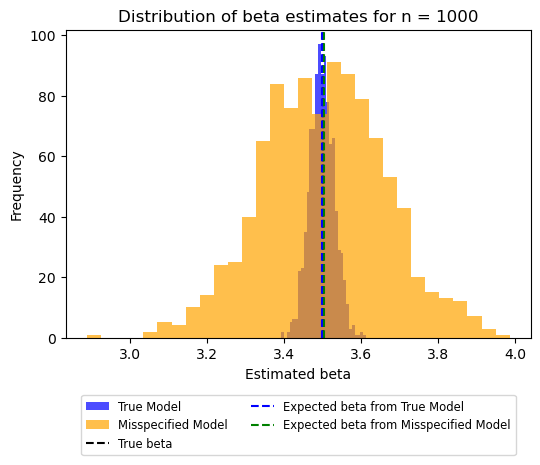

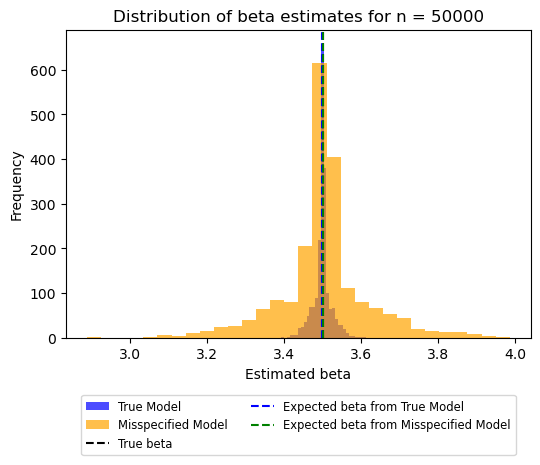

In [7]:
# Setting seed for reproducibility
np.random.seed(42)

n = [1000, 50000] # sample size
B = 1000 # number of simulations

# Setting true value of parameters
alpha = 1
beta = 3.5
gamma = 5

# Initiating list for the estimated parameters for the correct model
beta_estimates_1 = []


# Initiating list for the estimated parameters for the misspecified model
beta_estimates_2 = []

# Creating Monte Carlo simulations
for _ in n:

    for b in range(B):

        # Generating the Variables

        X = np.random.normal(0,1,_) # Creating a hypothetical observed value of X

        W = np.random.normal(0,1,_) # Creating a hypothetical observed value of W

        epsilon = np.random.normal(0,1,_) # Epsilon following standard OLS assumptions

        # True Model
        Y = alpha + beta * X + gamma * W + epsilon

        # Creating a Dataframe for use
        data = pd.DataFrame({'Y': Y, 'X': X, 'W': W})

        # Fitting the True Model to get the estimates 

        controls = data[['X', 'W']]
        depvar = data['Y']
        controls = sm.add_constant(controls)

        model_true = sm.OLS(depvar, controls).fit()
        beta_estimates_1.append(model_true.params[1])

        # Fitting the Misspecified Model to get the estimates

        controls_false = data[['X']]
        depvar_false = data['Y']
        controls_false = sm.add_constant(controls_false)

        model_false = sm.OLS(depvar_false, controls_false).fit()
        beta_estimates_2.append(model_false.params[1])


    plt.figure(figsize=(6, 4))
    plt.hist(beta_estimates_1, bins=30, alpha=0.7, label='True Model', color='blue')
    plt.hist(beta_estimates_2, bins=30, alpha=0.7, label='Misspecified Model', color='orange')
    plt.axvline(beta, color='black', linestyle='--', label='True beta')
    plt.axvline(np.mean(beta_estimates_1), color='blue', linestyle='--', label='Expected beta from True Model')
    plt.axvline(np.mean(beta_estimates_2), color='green', linestyle='--', label='Expected beta from Misspecified Model')
    plt.title(f'Distribution of beta estimates for n = {_}')
    plt.xlabel('Estimated beta')
    plt.ylabel('Frequency')
    plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.4),
    fontsize='small',
    ncol=2
    )

We note that when the observed values of the variables are uncorrelated, the estimator $\beta$ is unbiased. But an interesting trend is noted when increasing the sample size from 1000 to 50000. When we increase the sample size, the estimated coefficients tend to get closer to the true value. This property is the consistency of the OLS estimator. Omitted variable does not tamper with the consistency of the OLS estimator, simply biases it, and increases its variance in the same sample size. We observe that when the sample size increases, the frequency of estimated parameters being close to the true value rises, the tails become flatter. We can say that $$\hat{\beta} \xrightarrow{n \to \infty} \beta$$

Generating correlated random variables

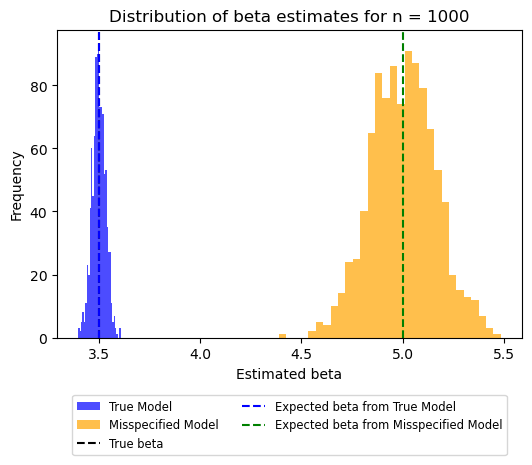

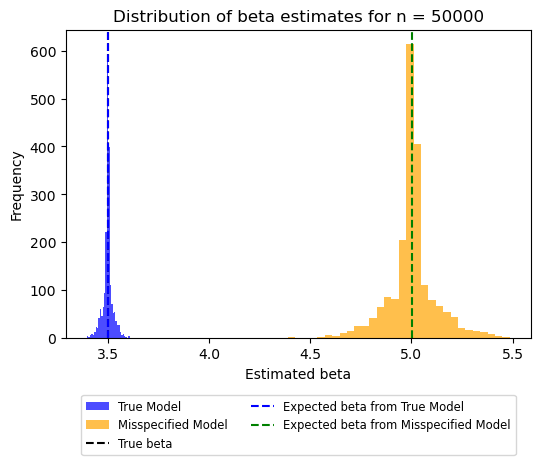

In [8]:
# Setting seed for reproducibility
np.random.seed(42)

n = [1000, 50000] # sample size
B = 1000 # number of simulations

# Setting true value of parameters
alpha = 1
beta = 3.5
gamma = 5

# Initiating list for the estimated parameters for the correct model
beta_estimates_1 = []


# Initiating list for the estimated parameters for the misspecified model
beta_estimates_2 = []

# Creating Monte Carlo simulations
for _ in n:

    for b in range(B):

        # Generating the Variables

        X = np.random.normal(0,1,_) # Creating a hypothetical observed value of X

        W = 0.3 * X + np.random.normal(0,1,_) # Creating a hypothetical observed value of W

        epsilon = np.random.normal(0,1,_) # Epsilon following standard OLS assumptions

        # True Model
        Y = alpha + beta * X + gamma * W + epsilon

        # Creating a Dataframe for use
        data = pd.DataFrame({'Y': Y, 'X': X, 'W': W})

        # Fitting the True Model to get the estimates 

        controls = data[['X', 'W']]
        depvar = data['Y']
        controls = sm.add_constant(controls)

        model_true = sm.OLS(depvar, controls).fit()
        beta_estimates_1.append(model_true.params[1])

        # Fitting the Misspecified Model to get the estimates

        controls_false = data[['X']]
        depvar_false = data['Y']
        controls_false = sm.add_constant(controls_false)

        model_false = sm.OLS(depvar_false, controls_false).fit()
        beta_estimates_2.append(model_false.params[1])


    plt.figure(figsize=(6, 4))
    plt.hist(beta_estimates_1, bins=30, alpha=0.7, label='True Model', color='blue')
    plt.hist(beta_estimates_2, bins=30, alpha=0.7, label='Misspecified Model', color='orange')
    plt.axvline(beta, color='black', linestyle='--', label='True beta')
    plt.axvline(np.mean(beta_estimates_1), color='blue', linestyle='--', label='Expected beta from True Model')
    plt.axvline(np.mean(beta_estimates_2), color='green', linestyle='--', label='Expected beta from Misspecified Model')
    plt.title(f'Distribution of beta estimates for n = {_}')
    plt.xlabel('Estimated beta')
    plt.ylabel('Frequency')
    plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.4),
    fontsize='small',
    ncol=2
    )

# Problem 2: 

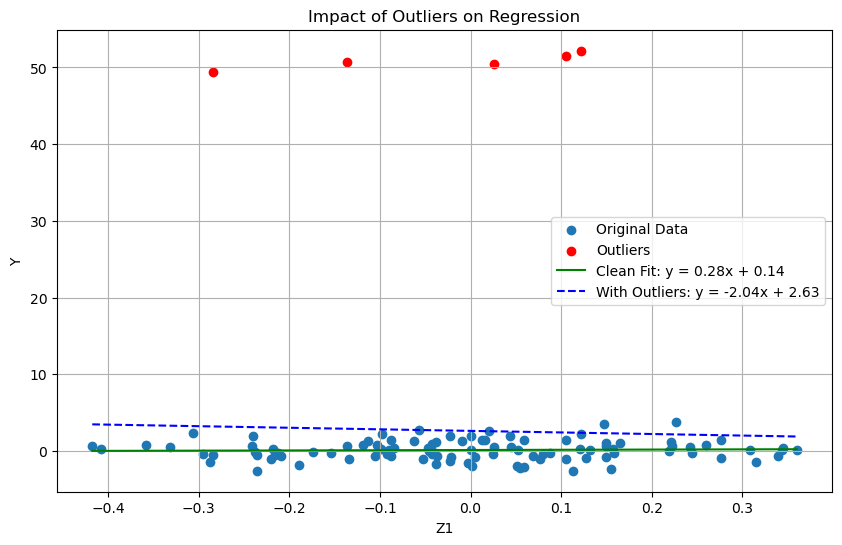

In [9]:
# Loading the data
df = pd.read_csv("FE-GWP1_model_selection_2.csv")

# Cleaning the columkn names
df.columns = df.columns.str.strip()

# Using Z1 as predictor and Y as response
X = df[['Z1']].values
Y = df[['Y']].values

# Model without outliers
model_clean = LinearRegression()
model_clean.fit(X, Y)
slope_clean = model_clean.coef_[0][0]
intercept_clean = model_clean.intercept_[0]

# Introducing outliers in first 5 rows
Y_outliers = Y.copy()
Y_outliers[:5] += 50

# Model with outliers
model_outliers = LinearRegression()
model_outliers.fit(X, Y_outliers)
slope_outlier = model_outliers.coef_[0][0]
intercept_outlier = model_outliers.intercept_[0]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, label="Original Data")
plt.scatter(X[:5], Y_outliers[:5], color="red", label="Outliers")

x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
plt.plot(x_range, model_clean.predict(x_range), color="green", label=f"Clean Fit: y = {slope_clean:.2f}x + {intercept_clean:.2f}")
plt.plot(x_range, model_outliers.predict(x_range), color="blue", linestyle="--", label=f"With Outliers: y = {slope_outlier:.2f}x + {intercept_outlier:.2f}")

plt.xlabel("Z1")
plt.ylabel("Y")
plt.title("Impact of Outliers on Regression")
plt.legend()
plt.grid(True)
plt.show() 

# Problem 3a

For this question, since our group number is odd, FE-GWP1_model_seletion_1.csv is chosen.

We use Backward Selection using AIC and Forward Selection using Adjusted $R^2$ to choose the best set of features and create an optimal model. 

In [10]:
# Load the dataset
df = pd.read_csv('FE-GWP1_model_selection_2.csv')
df.columns = df.columns.str.strip()

# View first few rows
df.head()

,Y,Z1,Z2,Z3,Z4,Z5
0,2.172296,0.121634,-0.051562,0.570616,1.279931,0.075233
1,0.502380,0.025446,-0.093062,0.304875,-0.582292,0.377388
2,0.711362,-0.136716,-0.082229,-0.191680,-0.647970,1.230986
3,-0.557168,-0.284459,-0.170922,-0.853670,-1.256146,-0.991686
4,1.500199,0.105205,-0.169141,0.826558,0.640945,1.099873


## OLS Regression

In [11]:
full_model = ols('Y ~ Z1 + Z2 + Z3 + Z4 + Z5', data=df).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3062.
Date:                Tue, 17 Jun 2025   Prob (F-statistic):          2.07e-102
Time:                        11:48:41   Log-Likelihood:                 88.951
No. Observations:                 100   AIC:                            -165.9
Df Residuals:                      94   BIC:                            -150.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0097      0.013     77.496      0.0

## Backward Selection using AIC

AIC penalizes the number of parameters used in the model. AIC would only prefer removal of a variable from the complete regression model when the variable doesn't significantly contribute to the model. This prevents from overfitting.

AIC is used in feature selection here since AIC is an in-sample information criterion which results in a simple model helpful for interpretation. Thus, the result from Backward Selection using AIC results in the simplest and an interpretable model.

In [12]:
def compute_aic(features):
    formula = 'Y ~ ' + ' + '.join(features)
    model = ols(formula, data=df).fit()
    return model.aic, model

# Initialize
features = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
best_aic = compute_aic(features)[0]
current_features = features.copy()

improvement = True

# Backward elimination loop
while improvement and len(current_features) > 1:
    aic_values = []
    models = []
    for feature in current_features:
        test_features = current_features.copy()
        test_features.remove(feature)
        aic, model = compute_aic(test_features)
        aic_values.append((aic, feature, model))
    
    # Find best candidate to remove
    aic_values.sort()
    best_candidate = aic_values[0]
    
    if best_candidate[0] < best_aic:
        print(f'Removing {best_candidate[1]} --> AIC improved from {best_aic:.2f} to {best_candidate[0]:.2f}')
        best_aic = best_candidate[0]
        current_features.remove(best_candidate[1])
    else:
        improvement = False

# Final selected model
final_backward_model = compute_aic(current_features)[1]
print(final_backward_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3062.
Date:                Tue, 17 Jun 2025   Prob (F-statistic):          2.07e-102
Time:                        11:48:41   Log-Likelihood:                 88.951
No. Observations:                 100   AIC:                            -165.9
Df Residuals:                      94   BIC:                            -150.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0097      0.013     77.496      0.0

## Forward Selection using Adjusted $R^2$

Adjusted-$R^2$ unlike $R^2$ doesn't always increase as we add variables in the regression mechanism. Adjusted $R^2$ is inversely related to the number of variables used in the regression. Thus, it decreases with the addition of a variable which doesn't add significant addition to the model. 
Due to this property of adjusted-$R^2$, we generally use Forward Selection using Adjusted $R^2$ (rather than Backward Selection).

In [13]:
def compute_adj_r2(features):
    if len(features) == 0:
        return -np.inf, None
    formula = 'Y ~ ' + ' + '.join(features)
    model = ols(formula, data=df).fit()
    return model.rsquared_adj, model

# Initialize
all_features = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
selected_features = []
remaining_features = all_features.copy()
best_adj_r2 = -np.inf

improvement = True

# Forward selection loop
while improvement and remaining_features:
    adj_r2_values = []
    models = []
    for feature in remaining_features:
        test_features = selected_features + [feature]
        adj_r2, model = compute_adj_r2(test_features)
        adj_r2_values.append((adj_r2, feature, model))
    
    # Find best candidate to add
    adj_r2_values.sort(reverse=True)
    best_candidate = adj_r2_values[0]
    
    if best_candidate[0] > best_adj_r2:
        print(f'Adding {best_candidate[1]} --> Adjusted R² improved from {best_adj_r2:.4f} to {best_candidate[0]:.4f}')
        best_adj_r2 = best_candidate[0]
        selected_features.append(best_candidate[1])
        remaining_features.remove(best_candidate[1])
    else:
        improvement = False

# Final selected model
final_forward_model = compute_adj_r2(selected_features)[1]
print(final_forward_model.summary())

Adding Z4 --> Adjusted R² improved from -inf to 0.8561
Adding Z3 --> Adjusted R² improved from 0.8561 to 0.9556
Adding Z5 --> Adjusted R² improved from 0.9556 to 0.9828
Adding Z2 --> Adjusted R² improved from 0.9828 to 0.9895
Adding Z1 --> Adjusted R² improved from 0.9895 to 0.9936
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3062.
Date:                Tue, 17 Jun 2025   Prob (F-statistic):          2.07e-102
Time:                        11:48:41   Log-Likelihood:                 88.951
No. Observations:                 100   AIC:                            -165.9
Df Residuals:                      94   BIC:                            -150.3
Df Model:                           5                                         
Covari

We performed both backward selection (using AIC) and forward selection (using Adjusted R²) to determine the best subset of variables for predicting Y.

* The backward selection process showed that the lowest AIC (-165.9) is achieved when all variables (Z1 to Z5) are included in the model. At each step of backward elimination, removing any variable led to an increase in AIC, indicating that each variable contributes to improving model fit.

* The forward selection process, based on Adjusted R², also consistently selected all variables, resulting in a model with an Adjusted R² of 0.994 — indicating excellent explanatory power.

Thus, both selection methods lead to the same conclusion: the model including all variables provides the best balance of predictive performance (lowest AIC) and explanatory power (highest Adjusted R²). We therefore conclude that including all five variables in the model is optimal in terms of both interpretability and predictability.

# Problem 5b: Checking Stationarity

In [14]:
# NSE dataset is used to check for stationarity.
df = pd.read_csv('NSEI.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,22-05-2025,"24,599.90","24,733.95","24,733.95","24,542.90",147.64M,-0.86%
1,21-05-2025,"24,813.45","24,744.25","24,946.20","24,685.35",332.72M,0.52%
2,20-05-2025,"24,683.90","24,996.20","25,010.35","24,669.70",414.80M,-1.05%
3,19-05-2025,"24,945.45","25,005.35","25,062.95","24,916.65",255.25M,-0.30%
4,16-05-2025,"25,019.80","25,064.65","25,070.00","24,953.05",432.72M,-0.17%
...,...,...,...,...,...,...,...
4300,07-01-2008,"6,279.10","6,271.00","6,289.80","6,193.35",139.61M,0.08%
4301,04-01-2008,"6,274.30","6,179.10","6,300.05","6,179.10",147.63M,1.55%
4302,03-01-2008,"6,178.55","6,184.25","6,230.15","6,126.40",156.36M,-0.01%
4303,02-01-2008,"6,179.40","6,144.70","6,197.00","6,060.85",110.35M,0.57%


In [15]:
cutoff_date = pd.to_datetime('22-05-2015')
df['Date'] = pd.to_datetime(df['Date'])
df1 = df[df['Date'] >= cutoff_date].copy()
df1.set_index('Date', inplace=True)
df1.sort_index(inplace=True)
df1['Price'] = df1['Price'].str.replace(',', '').astype(float)

In [16]:
df1

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2015-05-22,8458.95,"8,432.50","8,489.55","8,420.60",193.08M,0.45%
2015-05-25,8370.25,"8,438.15","8,441.95","8,364.15",125.05M,-1.05%
2015-05-26,8339.35,"8,377.10","8,378.90","8,320.05",120.43M,-0.37%
2015-05-27,8334.60,"8,302.75","8,342.85","8,277.95",170.58M,-0.06%
2015-05-28,8319.00,"8,345.70","8,364.50","8,270.15",239.55M,-0.19%
...,...,...,...,...,...,...
2025-05-16,25019.80,"25,064.65","25,070.00","24,953.05",432.72M,-0.17%
2025-05-19,24945.45,"25,005.35","25,062.95","24,916.65",255.25M,-0.30%
2025-05-20,24683.90,"24,996.20","25,010.35","24,669.70",414.80M,-1.05%


## Original Series

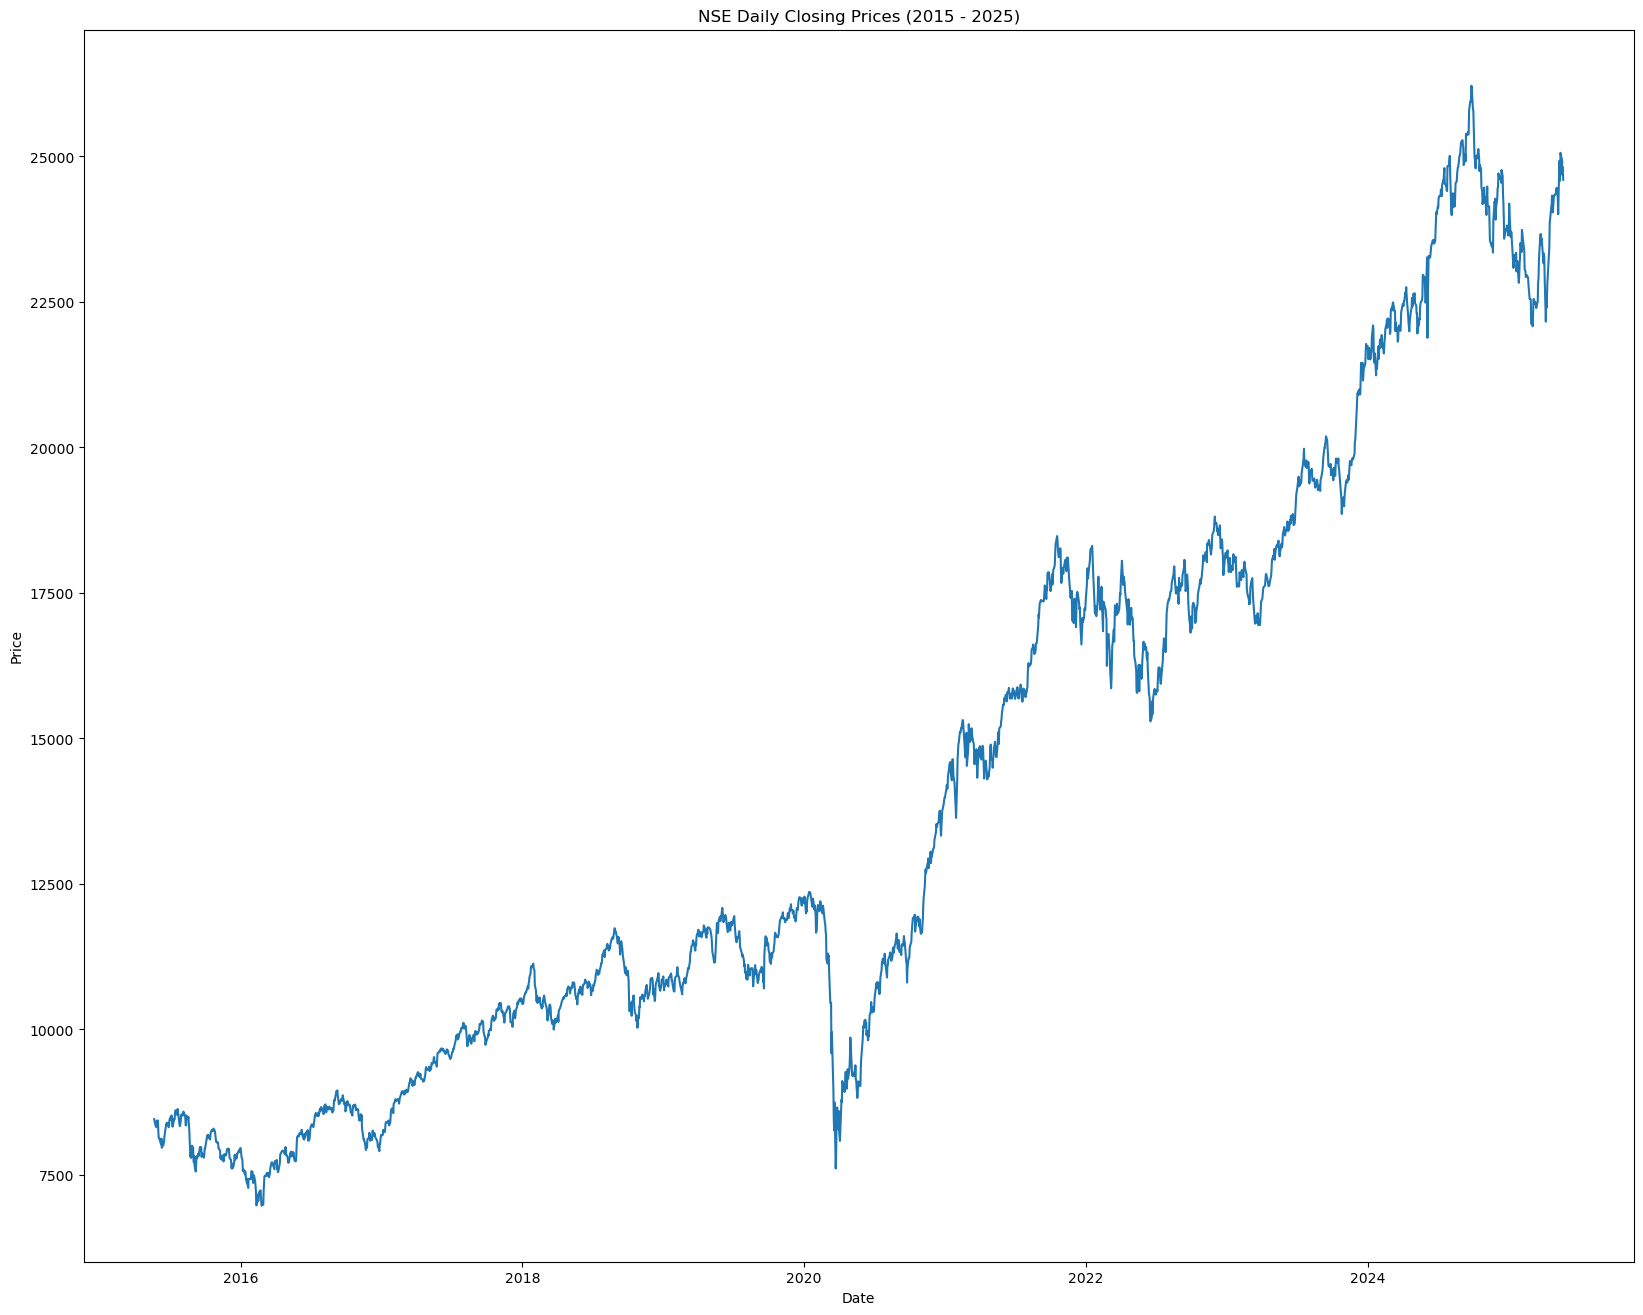

In [17]:
plt.figure(figsize=(20,16))
plt.plot(df1.index, df1['Price'])
plt.title('NSE Daily Closing Prices (2015 - 2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


## Augmented Dickey Fuller Tests to confirm non-stationarity

In [18]:
# Step 2: ADF test on price levels
adf_result_prices = adfuller(df1.Price.dropna())
print('ADF Statistic (Price levels):', adf_result_prices[0])
print('p-value:', adf_result_prices[1])
print('Critical Values:', adf_result_prices[4])

ADF Statistic (Price levels): 0.4014150796772539
p-value: 0.9815477833617648
Critical Values: {'1%': -3.4329927491693426, '5%': -2.8627075477802673, '10%': -2.567391531704927}


We can visually observe a trend in the series which signifies non-stationarity. Further, the p-value of ADF statistic is too high. Thus, we cannot reject the null Hypothesis that the series is non-stationary.

Lets check after differencing the series.

## First Differencing

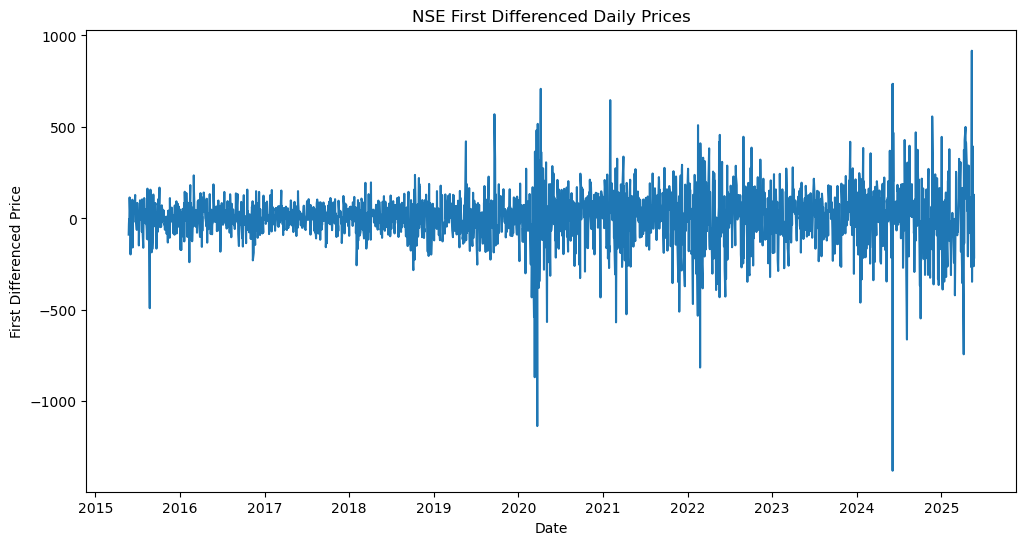

In [19]:

diff_1 = df1.Price.diff()

# Plot log returns
plt.figure(figsize=(12,6))
plt.plot(diff_1)
plt.title('NSE First Differenced Daily Prices')
plt.xlabel('Date')
plt.ylabel('First Differenced Price')
plt.show()

In [20]:
a = adfuller(diff_1.dropna())
print('ADF Statistic (Log Returns):', a[0])
print('p-value:', a[1])
print('Critical Values:', a[4])

ADF Statistic (Log Returns): -50.70846048597703
p-value: 0.0
Critical Values: {'1%': -3.4329938176251593, '5%': -2.8627080196071697, '10%': -2.567391782912405}


The differenced series look like it has a constant mean, but we can't visually justify constant variance.
Although, the p-value of ADF test is lower than 0.01, thus with 99% confidence we can reject the null hypothesis that the series is non-stationary. 

Since, we observe varying variance in the differenced series, we must check differenced log returns.

## First Differenced Log Returns

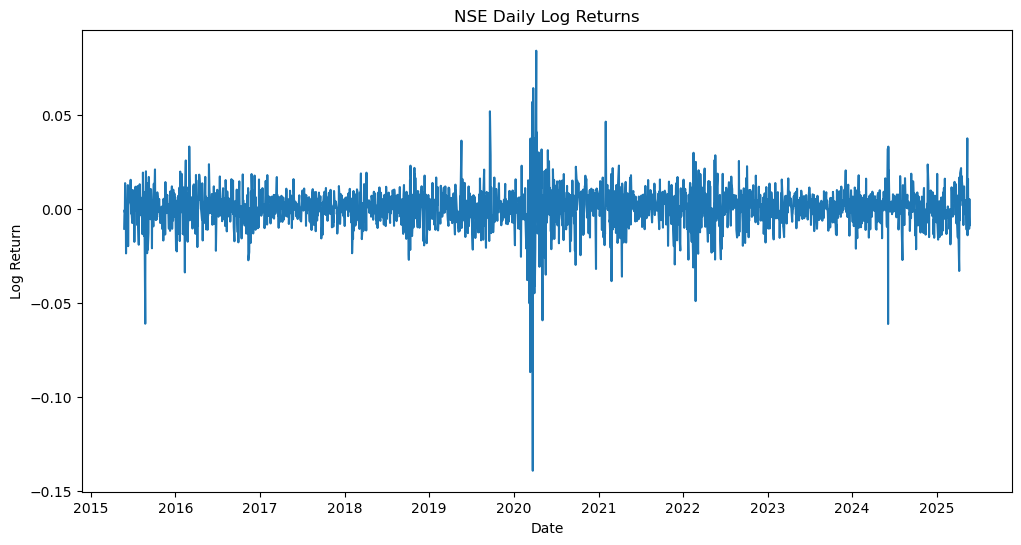

In [21]:
log_prices = np.log(df1.Price)
log_diff = log_prices.diff().dropna()

# Plot log returns
plt.figure(figsize=(12,6))
plt.plot(log_diff)
plt.title('NSE Daily Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

In [22]:
# Step 4: ADF test on log returns
adf_result_returns = adfuller(log_diff)
print('ADF Statistic (Log Returns):', adf_result_returns[0])
print('p-value:', adf_result_returns[1])
print('Critical Values:', adf_result_returns[4])

ADF Statistic (Log Returns): -13.699583842907856
p-value: 1.2973124369889407e-25
Critical Values: {'1%': -3.433005627914427, '5%': -2.862713234984453, '10%': -2.567394559656695}


The differenced log series looks stationary and so does the ADF test state. The p-value of ADF Test is less than 0.01, thus with 99% confidence, we can reject the null hypothesis that the series is non-stationary.

# Problem 5c: Monte Carlo Simulation
## Visualizing Unit root and Explosive root.

In [23]:
n = 500
white_noise = np.random.normal(0, 1, n)

# AR(1) with phi = 1 (unit root)
x_unit_root = np.zeros(n)
for t in range(1, n):
    x_unit_root[t] = x_unit_root[t-1] + white_noise[t]

# AR(1) with phi = 1.5 (explosive root)
x_explosive = np.zeros(n)
for t in range(1, n):
    x_explosive[t] = 1.5 * x_explosive[t-1] + white_noise[t]

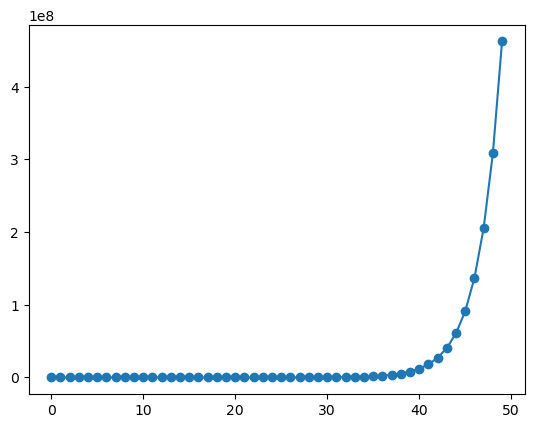

In [24]:
n = 50
e = np.random.normal(0, 1, n)
x_explosive = np.zeros(n)
for t in range(1, n):
    x_explosive[t] = 1.5 * x_explosive[t-1] + e[t]
    
plt.plot(x_explosive, marker = 'o')
plt.show()

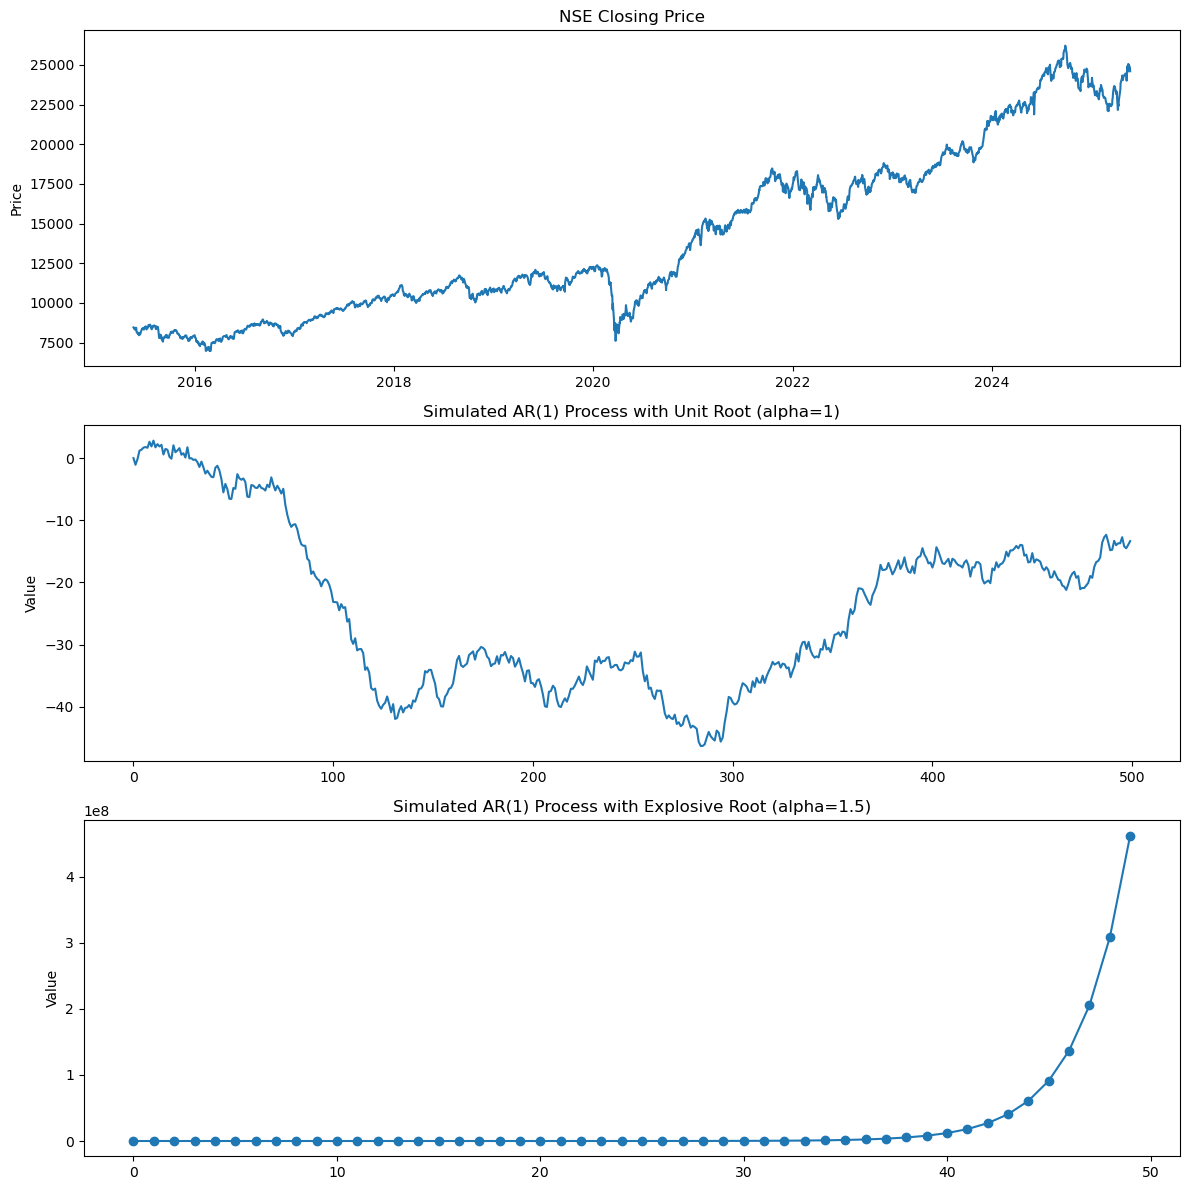

In [25]:
# Plotting the series
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Plot actual equity data
axes[0].plot(df1.Price)
axes[0].set_title("NSE Closing Price")
axes[0].set_ylabel("Price")

# Plot unit root simulation
axes[1].plot(x_unit_root)
axes[1].set_title("Simulated AR(1) Process with Unit Root (alpha=1)")
axes[1].set_ylabel("Value")

# Plot explosive root simulation
axes[2].plot(x_explosive, marker = 'o')
axes[2].set_title("Simulated AR(1) Process with Explosive Root (alpha=1.5)")
axes[2].set_ylabel("Value")

plt.tight_layout()

From the above visualization, we can observe that unit root is more closely linked with the real life financial dataset (NSE) compared to the explosive root. There are a ton of series which look very similar to the scenario with unit root. 

Thus, we focus on detecting unit root rather than explosive roots, since they are rather rarer in real world.

# Problem 6:

#### Dummy Variable Regression

The Average Root Mean Squared Error of Model 1 without a dummy variable is: 1.6555757753922227
The Average Root Mean Squared Error of Model 2 with a dummy variable is: 0.9108437392001528


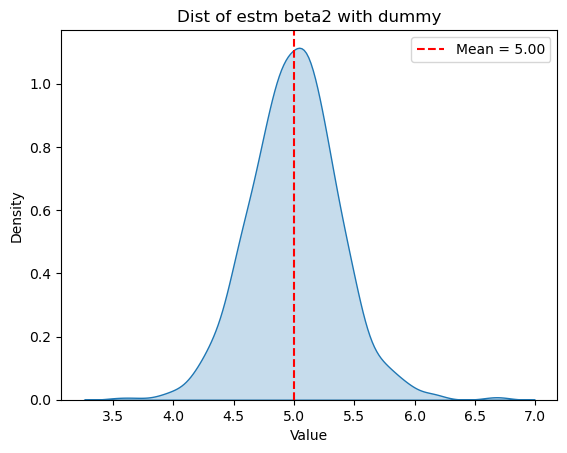

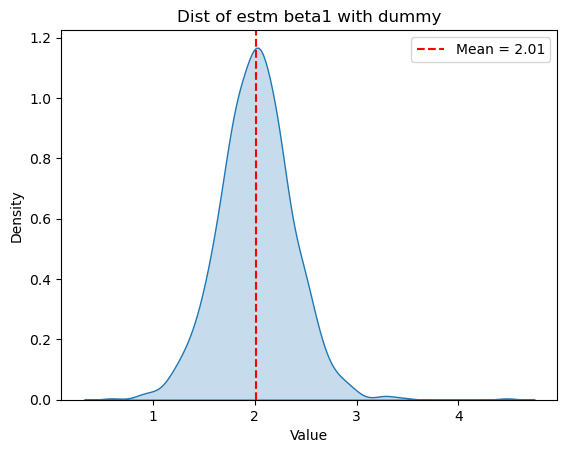

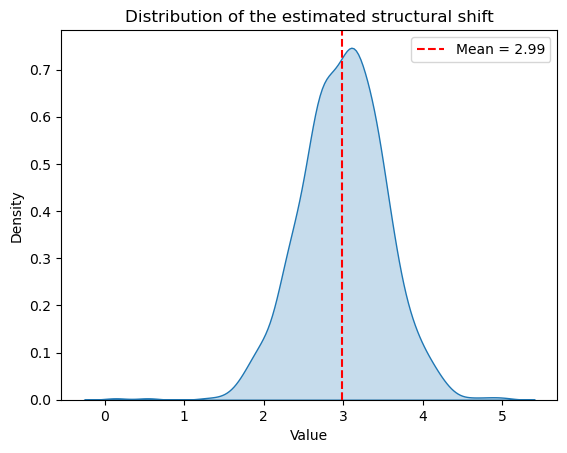

In [26]:
np.random.seed(42)

T = 20
alpha = 1
beta1 = 2
beta2 = 5 # Adding a structural break

B = 1000 # number of simulations
timestamp = np.arange(1,T+1)


beta_model_1 = []
beta_1_model_2 = []
delta_model_2 = []
beta_2_model_2 = []
rmse_1_no_dummy = []
rmse_2_dummy = []


for _ in range(B):


    X = np.random.normal(0,1,T)

    beta = np.where(timestamp <= 10, beta1, beta2) # Adding a structural break to test later
    epsilon = np.random.normal(0,1,T) # error term
    Y = alpha + beta * X + epsilon # construction of Y

    # Creating a dataframe to simulate the actual effect. We dont construct the data, we generally get it. If we find a structural shift    

    df = pd.DataFrame({
        'timestamp': timestamp,
        'X': X,
        'Y': Y
    })                                  

    df["time_dummy"] = np.where(df["timestamp"] <= 10, 0, 1) # Creating a dummy variable for the timestamp <=10

    df["treatment_var"] = df["X"] * df["time_dummy"] # Dummy Variable Dt*Xt

    # Model 1: No Dummy

    control_no_dummy = df[["X"]]
    y_no_dummy = df["Y"]
    control_no_dummy = sm.add_constant(control_no_dummy)

    model_no_dummy = sm.OLS(y_no_dummy, control_no_dummy).fit()

    beta_no_dummy = model_no_dummy.params[1]

    y_pred_no_dummy = model_no_dummy.predict(control_no_dummy)
    rmse_no_dummy = np.sqrt(np.mean((y_no_dummy - y_pred_no_dummy)**2))

    beta_model_1.append(beta_no_dummy) 
    rmse_1_no_dummy.append(rmse_no_dummy)

    # Model 2: Dummy

    control_dummy = df[["X", "treatment_var"]]
    y_dummy = df["Y"]
    control_dummy = sm.add_constant(control_dummy)

    model_dummy = sm.OLS(y_dummy, control_dummy).fit()

    delta_dummy = model_dummy.params[2]
    beta_dummy = model_dummy.params[1]
    beta_2_dummy = beta_dummy + delta_dummy

    y_pred_dummy = model_dummy.predict(control_dummy)
    rmse_dummy = np.sqrt(np.mean((y_dummy - y_pred_dummy)**2))

    beta_1_model_2.append(beta_dummy)
    beta_2_model_2.append(beta_2_dummy)
    delta_model_2.append(delta_dummy)
    rmse_2_dummy.append(rmse_dummy)

# Printing the results

print(f"The Average Root Mean Squared Error of Model 1 without a dummy variable is: {np.mean(rmse_1_no_dummy)}")
print(f"The Average Root Mean Squared Error of Model 2 with a dummy variable is: {np.mean(rmse_2_dummy)}")

sns.kdeplot(beta_2_model_2, fill=True)
plt.axvline(np.mean(beta_2_model_2), color='red', linestyle='--', label=f'Mean = {np.mean(beta_2_model_2):.2f}')
plt.legend()
plt.title("Dist of estm beta2 with dummy")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

sns.kdeplot(beta_1_model_2, fill=True)
plt.axvline(np.mean(beta_1_model_2), color='red', linestyle='--', label=f'Mean = {np.mean(beta_1_model_2):.2f}')
plt.legend()
plt.title("Dist of estm beta1 with dummy")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

sns.kdeplot(delta_model_2, fill=True)
plt.axvline(np.mean(delta_model_2), color='red', linestyle='--', label=f'Mean = {np.mean(delta_model_2):.2f}')
plt.legend()
plt.title("Distribution of the estimated structural shift")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()